In [7]:
import boto3

session = boto3.Session(profile_name='my-dev-profile')
ec2_client = session.client('ec2')

name_tag = 'mlflow-server'

# Get the EC2 instance response based on the name tag
response = ec2_client.describe_instances(
    Filters=[
        {
            'Name': 'tag:Name',
            'Values': [name_tag]
        }
    ]
)

# Get the public IP address of the current EC2 instance
public_ip_address = response['Reservations'][0]['Instances'][0]['PublicIpAddress']

In [8]:
public_ip_address

'52.58.237.228'

In [2]:
# Get the instance ID of the current EC2 instance
instance_id = 'i-0e907da21b460b6fd'

import mlflow

remote_tracking_uri = f'http://{public_ip_address}:5000/'
mlflow.set_tracking_uri(remote_tracking_uri)
mlflow.set_experiment('/dutch-fuel-prediction')

from mlflow.models import infer_signature
import pandas as pd
import statsmodels.api as sm
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit

In [3]:
X_train, y_train, X_test, y_test = pickle.load(open('../data/processed/X_y_data.pickle', 'rb'))

/home/emile/.cache/pypoetry/virtualenvs/dutch-fuel-prices-mNnnt_qf-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emile/.cache/pypoetry/virtualenvs/dutch-fuel-prices-mNnnt_qf-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emile/.cache/pypoetry/virtualenvs/dutch-fuel-prices-mNnnt_qf-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/emile/.cache/pypoetry/virtualenvs/du

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Eu95'>)

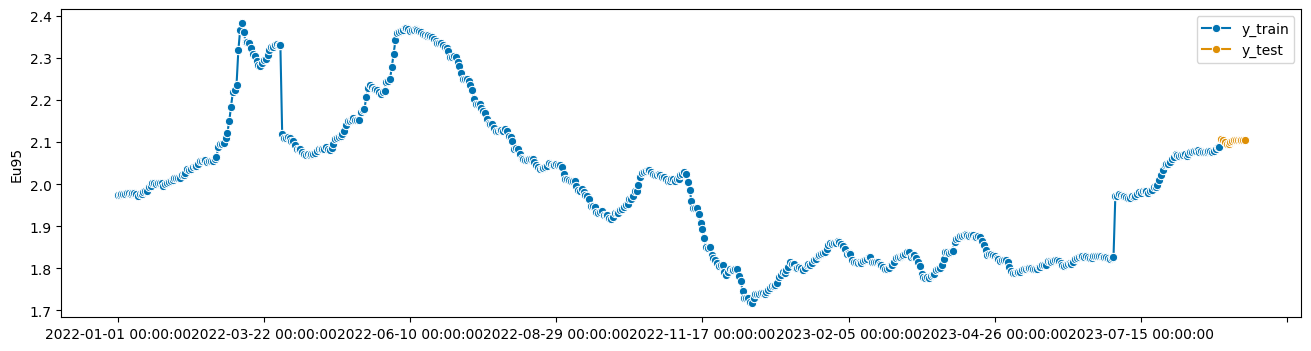

In [4]:
from sktime.utils.plotting import plot_series

plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [5]:
with mlflow.start_run():
    ols = sm.OLS(y_train, X_train).fit()
    predictions = ols.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    
    train_predictions = ols.predict(X_train)
    signature = infer_signature(X_train, train_predictions)

    mlflow.log_metric('rmse', rmse)

    mlflow.statsmodels.log_model(
        statsmodels_model=ols,
        artifact_path='models/ols',
        registered_model_name='statsmodels-ols-model',
    )
    # mlflow.log_artifacts()
    # mlflow.statsmodels.log_model(ols, 'ols', signature=signature)

Registered model 'statsmodels-ols-model' already exists. Creating a new version of this model...
2023/09/27 11:29:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: statsmodels-ols-model, version 2
Created version '2' of model 'statsmodels-ols-model'.


In [51]:

tscv = TimeSeriesSplit(n_splits=5, gap=7)

date_column = []
prediction_column = []
true_column = []
scores = []


In [45]:
mlflow.autolog()

for train_idx, val_idx in tscv.split(X=X_train, y=y_train):
    model = sm.OLS(y_train.iloc[train_idx], X_train.iloc[train_idx]).fit()
    # Score the model
    dates = X_train.iloc[val_idx].index
    date_column.extend(dates)
    predictions = model.predict(X_train.iloc[val_idx])
    predictions = [round(x, 3) for x in predictions]
    prediction_column.extend(predictions)
    true_column.extend(y_train.iloc[val_idx])
    rmse = mean_squared_error(y_train.iloc[val_idx], predictions, squared=False)
    scores.append(rmse)

prediction_table = pd.DataFrame({'date': date_column, 'prediction': prediction_column, 'true': true_column}).set_index('date')
score = sum(scores) / len(scores)
print(f"Average RMSE: {score:.3f}")
print(f"Scores per fold: {[round(x, 3) for x in scores]}")

2023/09/22 11:29:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/09/22 11:29:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Average RMSE: 0.044
Scores per fold: [0.066, 0.032, 0.043, 0.033, 0.044]


In [13]:
for train_idx, val_idx in tscv.split(X=X_train, y=y_train):
    model = sm.OLS(y_train.iloc[train_idx], X_train.iloc[train_idx]).fit()
    # Score the model
    dates = X_train.iloc[val_idx].index
    date_column.extend(dates)
    predictions = model.predict(X_train.iloc[val_idx])
    predictions = [round(x, 3) for x in predictions]
    prediction_column.extend(predictions)
    true_column.extend(y_train.iloc[val_idx])
    rmse = mean_squared_error(y_train.iloc[val_idx], predictions, squared=False)
    scores.append(rmse)

prediction_table = pd.DataFrame({'date': date_column, 'prediction': prediction_column, 'true': true_column}).set_index('date')
score = sum(scores) / len(scores)
print(f"Average RMSE: {score:.3f}")
print(f"Scores per fold: {[round(x, 3) for x in scores]}")

Date
2023-09-04    2.107
2023-09-05    2.106
2023-09-06    2.101
2023-09-07    2.097
2023-09-08    2.096
2023-09-09    2.101
2023-09-10    2.104
Freq: D, Name: Eu95, dtype: float64